In [74]:
import Pkg
Pkg.add("Cbc")
Pkg.add("JuMP")

  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`


In [75]:
Pkg.add("GLPK")

  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`


In [76]:
Pkg.add("Gurobi")

  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`


In [77]:
using JuMP
using Cbc
using DelimitedFiles
using NBInclude
using GLPK
using Gurobi
const GUROBI_ENV = Gurobi.Env()
const L = 6

# constante epsilon
const ϵ = 0.00001

Academic license - for non-commercial use only - expires 2021-06-07


1.0e-5

In [78]:
test = reshape(1:25, 5, 5)
print(test)
print(test[2,2])

[1 6 11 16 21; 2 7 12 17 22; 3 8 13 18 23; 4 9 14 19 24; 5 10 15 20 25]7

# Projet Programmation Mathématiques Avancée et Applications
Hugo Miccinilli, Aboa Bouadou, Florian Jacta, Theo DI PIAZZA | 4GM

## Kidney exchange problem

### Introduction et formulation du problème

On s'intéresse au problème de don croisé de rein.  
**Qu'est ce que le don croisé ?**   
"Il arrive assez souvent qu’une personne soit volontaire pour faire don d’un rein à un proche, parent, conjoint ou ami, mais que le don soit impossible en raison d’une incompatibilité tissulaire avec le receveur. On appellera ces deux personnes la paire A. Une situation identique peut se retrouver ailleurs au sein d’une paire B. Il arrive parfois que le donneur de la paire A soit compatible avec le receveur de la paire B, et vice-versa que le donneur de la paire B soit compatible avec le receveur B. Cette situation – peu courante – peut permettre un « don croisé »." (source France-adot)  

**Représentation mathématique du problème**  
Lorsqu'il y a plusieurs paires patient-donneur, l'opération de greffe est plus compliquée à mettre en place. Mathématiquement, on considère un graphe orienté simple $G = (V,A)$ où V représente l'ensemble des couples patient-donneur $(P_i,D_i)$ et A représente les compatibilités entre entre les différentes paires, c'est à dire $(i,j) \in A$ si le donneur $D_i$ est compatible avec le patient $P_j$. Certains patients sont prioritaires par rapport à d'autres donc on affecte un score $w_{i,j}$ qui caractérise ce fait. Plus le score est elevé, plus le patient impliqué dans l'arc est prioritaire. Ce score peut être vu comme l'utilité d'un arc donné.

**Formulation**  
Comme indiqué dans l'énoncé, on peut associer des patients et des donneurs de sorte à former un cycle dans G. Pour des raisons opérationnelles (les différents greffes dans un cycle doivent se dérouler en même temps), il ne faut pas qu'un cycle soit trop long. Soit L la longueur maximale qu'on peut avoir dans un cycle choisi et soit $\mathcal{C}_L$ l'ensemble des cycles de G tels que $|c| \le L$ pour $c \in \mathcal{C}_L$. On définit $\mathcal{C}_L(i)$ comme l'ensemble des cycles qui contiennent un sommet $i \in V$ et $w_c = \sum \limits_{(i,j) \in c} w_{i,j}$ pour $c \in \mathcal{C}_L$. L'objectif du problème est de choisir l'ensemble des cycles qui permettra de maximiser l'utilité. Certains patients peuvent donc ne pas avoir de donneurs après résolution du problème. 

Le problème peut ainsi se formuler comme suit :  

*Variables*  
$\forall c \in \mathcal{C}_L, z_c = \{0,1\} = 1$ si le cycle c est choisi, 0 sinon  

*Objectif*  
$\sum \limits_{c \in \mathcal{C}_L} w_cz_c$ 

*Contraintes*  
$\sum \limits_{c \in \mathcal{C}_L(i)} z_c \le 1, \forall i \in V$  
$z \in \{0,1\}^{|\mathcal{C}_L|}$


Le problème ayant un très grand nombre de variables, on veut le résoudre en utilisant l'algorithme de branch and price. 

### Initialisation du problème

Avant de coder l'algorithme, on code quelques classes et fonctions qui seront utiles pour initialiser les instances du problème. On explique en détail ces fonctions dans les différents fichiers qu'on a inclut ci-dessous.

In [86]:
@nbinclude("Euristic.ipynb");
@nbinclude("dataparser.ipynb");
@nbinclude("classes.ipynb");
@nbinclude("traitement_noeuds.ipynb");
@nbinclude("branch_and_price.ipynb");
@nbinclude("colonnes.ipynb");

  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`


Academic license - for non-commercial use only - expires 2021-06-07


  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\xgodw\.julia\environments\v1.5\Manifest.toml`


In [80]:
# Pour chaque paire, on va récupérer les arcs dont ils sont l'origine (calcul du demi-degré extérieur des sommets du graphe)
function degreExt(kep)
    origine = Array{Array{Int64,1},1}()
    for v in 1:nv(kep)
        # On recupère les indices des arcs dont l'origine est v
        origin_v = Array{Int64,1}()
        for (ind,arc) in enumerate(edges(kep))
            if src(arc) == v
                push!(origin_v,ind)
            end
        end
        push!(origine,origin_v)
    end
    return origine
end

# Pour chaque paire, on va récupérer les arcs dont ils sont la destination (calcul du demi-degré intérieur des sommets)
function degreInt(kep)
    dest = Array{Array{Int64,1},1}()
    for v in 1:nv(kep)
        # On recupère les indices des arcs dont l'origine est v
        dest_v = Array{Int64,1}()
        for (ind,arc) in enumerate(edges(kep))
            if dst(arc) == v
                push!(dest_v,ind)
            end
        end
        push!(dest,dest_v)
    end
    return dest
end


degreInt (generic function with 1 method)

In [84]:
origine = degreExt(pool);
dest = degreInt(pool);

In [93]:
result = @timed solve_BP()

Current list of nodes to be processed:[1]
 Processing node 1 
Variables set to zero are:Int64[]
Variables set to one are:Int64[]
VALEUR SOLUTION z : [0.045454545454545456, 0.0]

POIDS SOLUTION z : 0.045454545454545456

COUT REDUIT : 6.0
 Cycle avec les arcs [1, 28, 78, 79, 153, 169] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 1.0]

POIDS SOLUTION z : 6.0

 Solution réalisable de valeur 6.0 trouvée 
COUT REDUIT : 6.0
 Cycle avec les arcs [45, 57, 130, 202, 233, 243] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 1.0]

POIDS SOLUTION z : 6.0

 Solution réalisable de valeur 6.0 trouvée 
COUT REDUIT : 6.0
 Cycle avec les arcs [4, 8, 73, 110, 159, 178] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.5, 0.5, 0.5]

POIDS SOLUTION z : 9.0

COUT REDUIT : 6.0
 Cycle avec les arcs [8, 73, 78, 171, 179, 204] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.5, 0.5, 0.5, 0.5]

POIDS SOLUTION z : 12.0

COUT REDUIT : 6.0
 Cycle avec les arcs [59, 79, 104, 155, 158, 207] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.5, 0.5, 0.5, 

COUT REDUIT : 1.4000000000000004
 Cycle avec les arcs [18, 103, 110, 159, 191] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.0, 0.16666666666666674, 0.5, 0.0, 0.0, 0.33333333333333337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.5, 0.16666666666666663, 0.16666666666666663, 0.5, 0.16666666666666663]

POIDS SOLUTION z : 17.833333333333332

COUT REDUIT : 1.166666666666666
 Cycle avec les arcs [39, 79, 106, 151, 155, 243] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.0, 0.1666666666666667, 0.5, 0.0, 0.0, 0.33333333333333337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.5, 0.16666666666666666, 0.16666666666666666, 0.5, 0.16666666666666663, 0.0]

POIDS SOLUTION z : 17.833333333333332

COUT REDUIT : 0.708333333333333
 Cycle avec les arcs [39, 73, 149, 182, 232, 243] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.0, 0.0, 0.47058823529411764, 0.0, 0.0588235294117647, 0.17647058823529413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5882352941176471, 0.0, 0.5294117647058824, 0.17647058823529413, 0.0

Variables set to zero are:[17, 55, 18, 11, 8, 1]
Variables set to one are:[56]
VALEUR SOLUTION z : [0.0, 1.0]

POIDS SOLUTION z : 5.0

 Solution réalisable de valeur 5.0 trouvée 
COUT REDUIT : 1.0
 Cycle avec les arcs [47, 56, 104, 130, 223, 243] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 1.0]

POIDS SOLUTION z : 6.0

 Solution réalisable de valeur 6.0 trouvée 
COUT REDUIT : -0.0
Node relaxation is solved to optimality
Node upper bound is 6.0
Node lower bound is 6.0
The optimal relaxation solution was integer
Feasible solution with value 6.0 found
LB=6.0,UB=6.0454545
Current list of nodes to be processed:[14]
 Processing node 14 
Variables set to zero are:[56, 17, 55, 18, 11, 8, 1]
Variables set to one are:Int64[]
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.6666666666666667, 0.33333333333333337, 0.3333333333333333, 0.3333333333333333, 0.0, 0.6666666666666667, 0.0, 0.0]

POIDS SOLUTION z : 16.666666666666668

COUT REDUIT :

Variables set to zero are:[106, 35, 104, 54, 58, 56, 17, 55, 18, 11, 8, 1]
Variables set to one are:Int64[]
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.0, 0.5714285714285714, 0.0, 0.0, 0.0, 0.0, 0.28571428571428575, 0.0, 0.28571428571428575, 0.42857142857142855, 0.5714285714285714, 0.0, 0.0, 0.1428571428571428, 0.0, 0.42857142857142855, 0.0, 0.4285714285714286]

POIDS SOLUTION z : 18.0

COUT REDUIT : 2.0
 Cycle avec les arcs [57, 81, 128, 195, 220] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.0, 0.5714285714285714, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.0, 0.2857142857142857, 0.4285714285714286, 0.5714285714285715, 0.0, 0.0, 0.1428571428571429, 0.0, 0.4285714285714286, 0.0, 0.4285714285714285, 0.0]

POIDS SOLUTION z : 18.000000000000004

COUT REDUIT : 0.9999999999999991
 Cycle avec les arcs [101, 107, 123, 191] ajouté 
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 0.0, 0.5714285714285714, 0.0, 0.0, 0.0, 0.0, 0.2857142857142858, 0.0, 0.2857142857142858, 0.4285714285714286, 0.5714285714285714, 0.0, 

Current list of nodes to be processed:[34, 35]
 Processing node 35 
Variables set to zero are:[153, 105, 107, 57, 106, 35, 104, 54, 58, 56, 17, 55, 18, 11, 8, 1]
Variables set to one are:[154]
VALEUR SOLUTION z : [0.0, 0.0, 0.0, 1.0, 0.0]

POIDS SOLUTION z : 6.0

 Solution réalisable de valeur 6.0 trouvée 
COUT REDUIT : -0.0
Node relaxation is solved to optimality
Node upper bound is 6.0
Node lower bound is 6.0
The optimal relaxation solution was integer
Feasible solution with value 6.0 found
LB=6.0,UB=6.0454545
Current list of nodes to be processed:[34]
 Processing node 34 
Variables set to zero are:[154, 153, 105, 107, 57, 106, 35, 104, 54, 58, 56, 17, 55, 18, 11, 8, 1]
Variables set to one are:Int64[]
VALEUR SOLUTION z : [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

POIDS SOLUTION z : 16.0

 Solution réalisable de valeur 16.0 trouvée 
COUT REDUIT : 2.3333333333333335
 Cycle avec les arcs [19, 79, 110, 156, 169, 201] ajouté 
VALEUR SOLUTION z 

(value = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], time = 2.5882965, bytes = 136892144, gctime = 0.0412208, gcstats = Base.GC_Diff(136892144, 0, 7, 2413609, 6623, 0, 41220800, 1, 0))

In [64]:
findall(x->x!=0,result[1]);
x = result[1]
sol= MetaDiGraph(nv(pool), 0)
for (ind,arc) in enumerate(edges(pool))
    if x[ind]!=0
        add_edge!(sol,src(arc),dst(arc))
    end
end

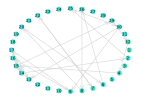

In [65]:
gplot(sol,layout=circular_layout,nodelabel = collect(1:nv(sol)))

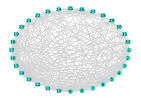

In [66]:
gplot(pool,layout=circular_layout,nodelabel = collect(1:nv(pool)))

In [29]:
dest[12]

6-element Array{Int64,1}:
  36
  65
 138
 191
 208
 221

Le sous problème associé au master s'écrit :
$$min \sum \limits_{a \in A} w_ax_a - \sum \limits_{i \in V} \pi_iy_i \\ s.l.c \sum \limits_{ a \in \delta^+(i)} x_a =   \sum \limits_{ a \in \delta^-(i)} x_a \text{,  } \forall i \in V \\ \sum \limits_{a \in A} x_a \le L \\ \sum \limits_{ a \in \delta^-(i)} x_a = y_i \text{,  } \forall i \in V \\ x \in \{0,1\}^{|A|} \\ y \in \{0,1\}^{|V|}$$

On cherche donc un cycle de longueur maximale égale à L qui minimise le coût réduit.
La fonction permettant d'initialiser le sous-problème est écrite dans le fichier *traitement_noeud*

In [30]:
# Ignore
pi = zeros(Int,17)
pi[4]=1
pi[13]=1
pi[14]=1
pi[15]=1

SP=Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV)))
set_optimizer_attribute(SP, "OutputFlag", 0)
    
# Definition x_a = 1 si l'arc a est dans le cycle retenu, 0 sinon
@variable(SP,x[a in 1:ne(pool)],Bin)
    
# Definition de y_i = 1 si paire i dans le cycle retenu, 0 sinon
@variable(SP,y[i in 1:nv(pool)],Bin)
    
    
for vertice in 1:nv(pool)
# Contraintes : les arcs doivent former un cycle
    @constraint(SP,sum(x[a] for a in origine[vertice]) == sum(x[a] for a in dest[vertice]) )
    #Contrainte : y_i vaut 1 ssi il y a un arc qui sort de la paire i qui est choisi dans le cycle
    @constraint(SP, y[vertice] == sum(x[a] for a in origine[vertice]))
end
    
# Contrainte : le cycle doit être de longueur inférieure à L 
@constraint(SP, sum(x[a] for a in 1:ne(pool)) <= L) 

# Contrainte : Il y a au moins un cycle, donc au moins deux sommets choisis
@constraint(SP, sum(y[v] for v in 1:nv(pool)) >= 1)
    
# Objectif : minimiser le coût réduit
@objective(SP,Max,sum( weights[a]*x[a] for a in 1:ne(pool) ) - sum(pi[i]*y[i] for i in 1:nv(pool) ))
    
optimize!(SP)

# If the subproblem is solved to optimality then return its objective value
# and the optimal cycle solution
# Else the pricing problem is infeasible return Inf, []
if JuMP.termination_status(SP)==MOI.OPTIMAL
    print("SOLUTION \nValeur optimale: ",JuMP.objective_value(SP),"\nCycle: ",JuMP.value.(x))
end

LoadError: BoundsError: attempt to access 17-element Array{Int64,1} at index [18]

In [31]:
collect(edges(pool))[42:47]

6-element Array{LightGraphs.SimpleGraphs.SimpleEdge{Int64},1}:
 Edge 4 => 20
 Edge 4 => 21
 Edge 4 => 23
 Edge 4 => 25
 Edge 4 => 27
 Edge 4 => 29

In [32]:
x = []
size(x,1)
isnothing(x)

false